In [217]:
import pandas as pd
import matplotlib.pyplot as plt

In [218]:
########## Balance mix strategy

In [219]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [220]:
### BM High-cap Scenario

In [221]:
h_BM_variables = pd.read_csv(r'../../results/highcap-BM-optimized-variables.csv', low_memory=False)

In [222]:
h_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [223]:
# Extract attributes from h_BM_variables
h_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
h_BM_variables = h_BM_variables.dropna()
h_BM_variables['Year'] = h_BM_variables['Year'].astype(int)

# Extract attributes from h_BM_coefficients
h_BM_coefficients[['Scenario', 'Year', 'Trip']] = h_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
h_BM_coefficients = h_BM_coefficients.dropna()
h_BM_coefficients['Year'] = h_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
h_BM_coefficients['Trip'] = h_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(h_BM_coefficients[['Powertrain','Scenario', 'Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Scenario', 'Year', 'Trip',],
                                how='left')

# Update h_BM_variables
h_BM_variables = merged_df

In [224]:
# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_BM_variables
h_BM_variables = merged_df

h_BM_variables['ServiceDateTime_min'] = pd.to_datetime(h_BM_variables['ServiceDateTime_min'])
h_BM_variables['ServiceDateTime_max'] = pd.to_datetime(h_BM_variables['ServiceDateTime_max'])
#h_BM_variables['Value'] = pd.to_numeric(h_BM_variables['Value'])

KeyError: "['TripKey'] not in index"

In [177]:
h_BM_variables.to_csv(r'../../results/highcap-BM-optimized-variables-aggregated.csv', index=False)

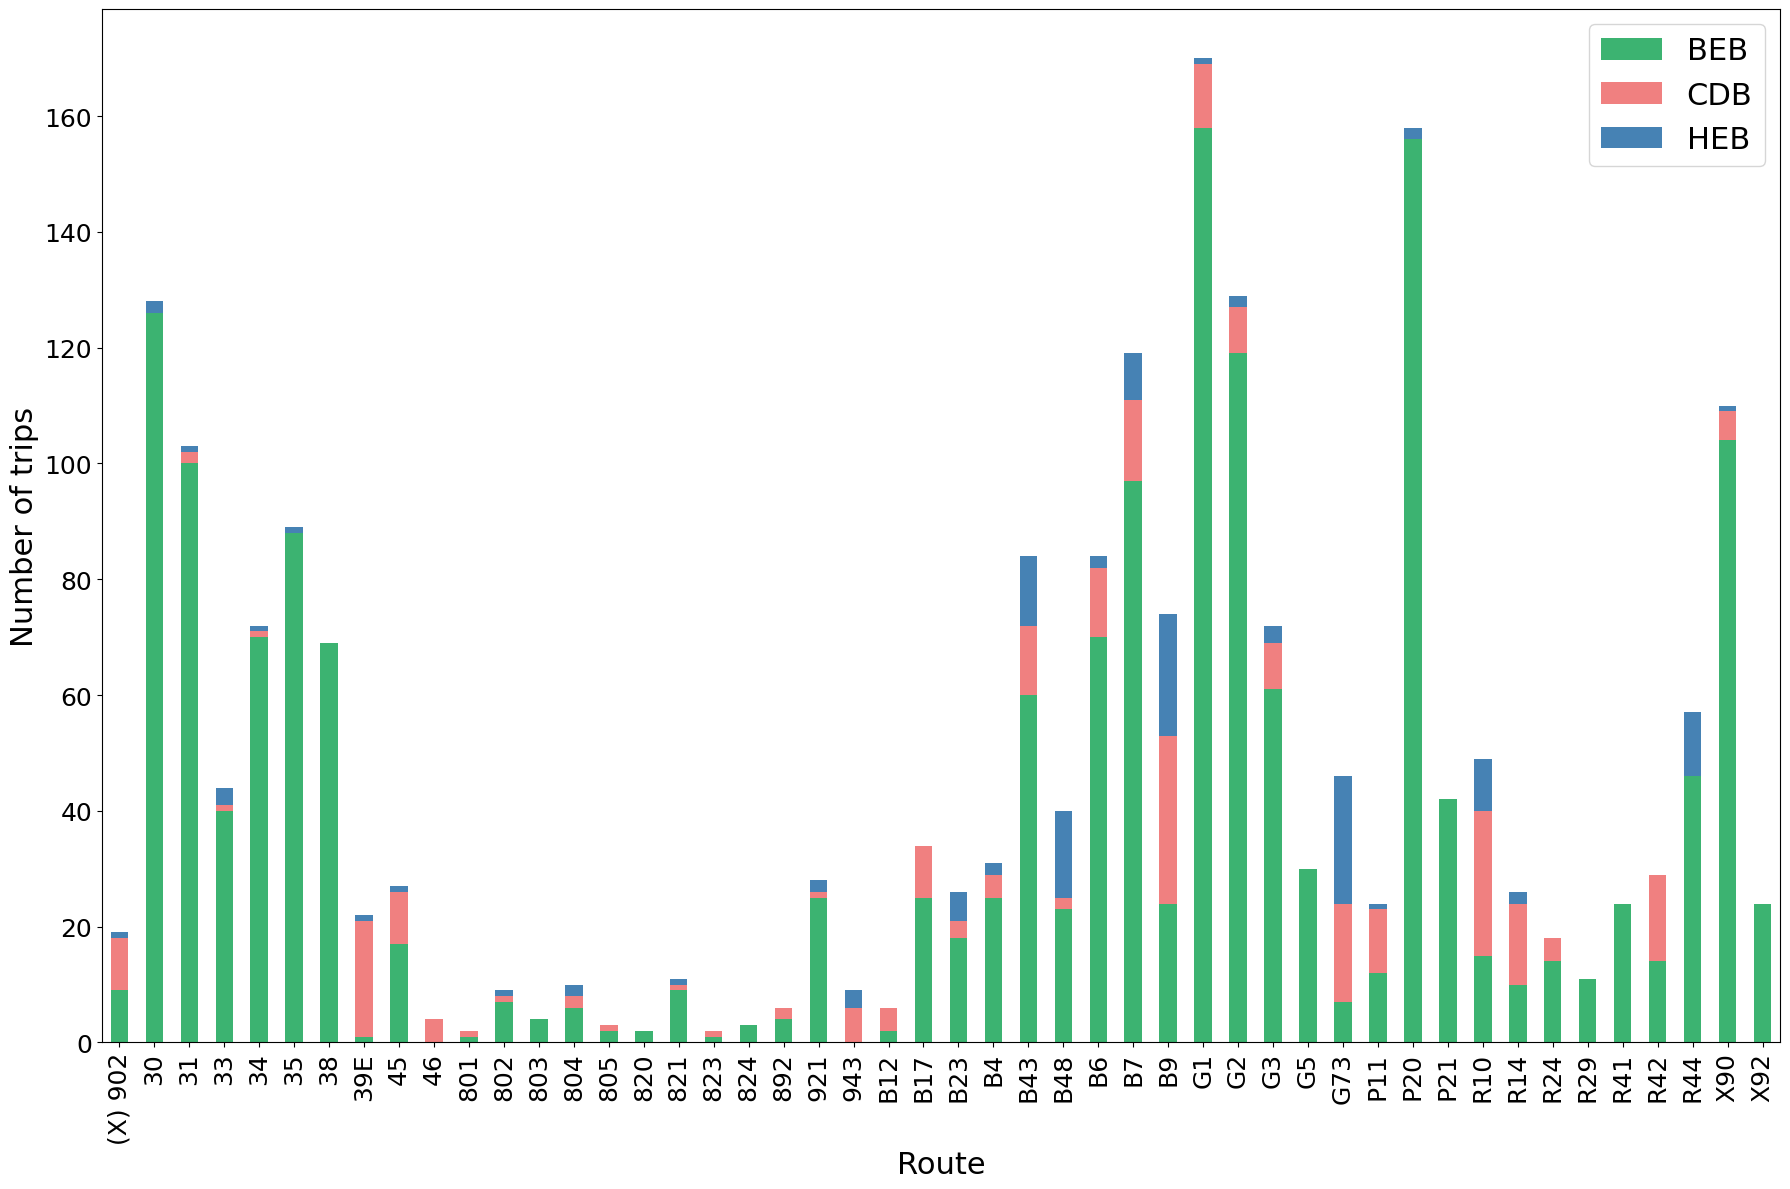

In [179]:
# Filter the dataframe for Year=13 and Value=1
h_BM_variables_filtered = h_BM_variables[(h_BM_variables['Year'] == 12) & (h_BM_variables['Value'] == 1)]
h_BM_variables_filtered = h_BM_variables_filtered[h_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()

fig.savefig(r'../../figures/h_BM_route_electrification.png', dpi=400)  

plt.show()


In [181]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 81.31%


In [187]:
h_BM_variables_y = pd.read_csv(r'../../results/highcap-BM-optimized-variables-y.csv', low_memory=False)

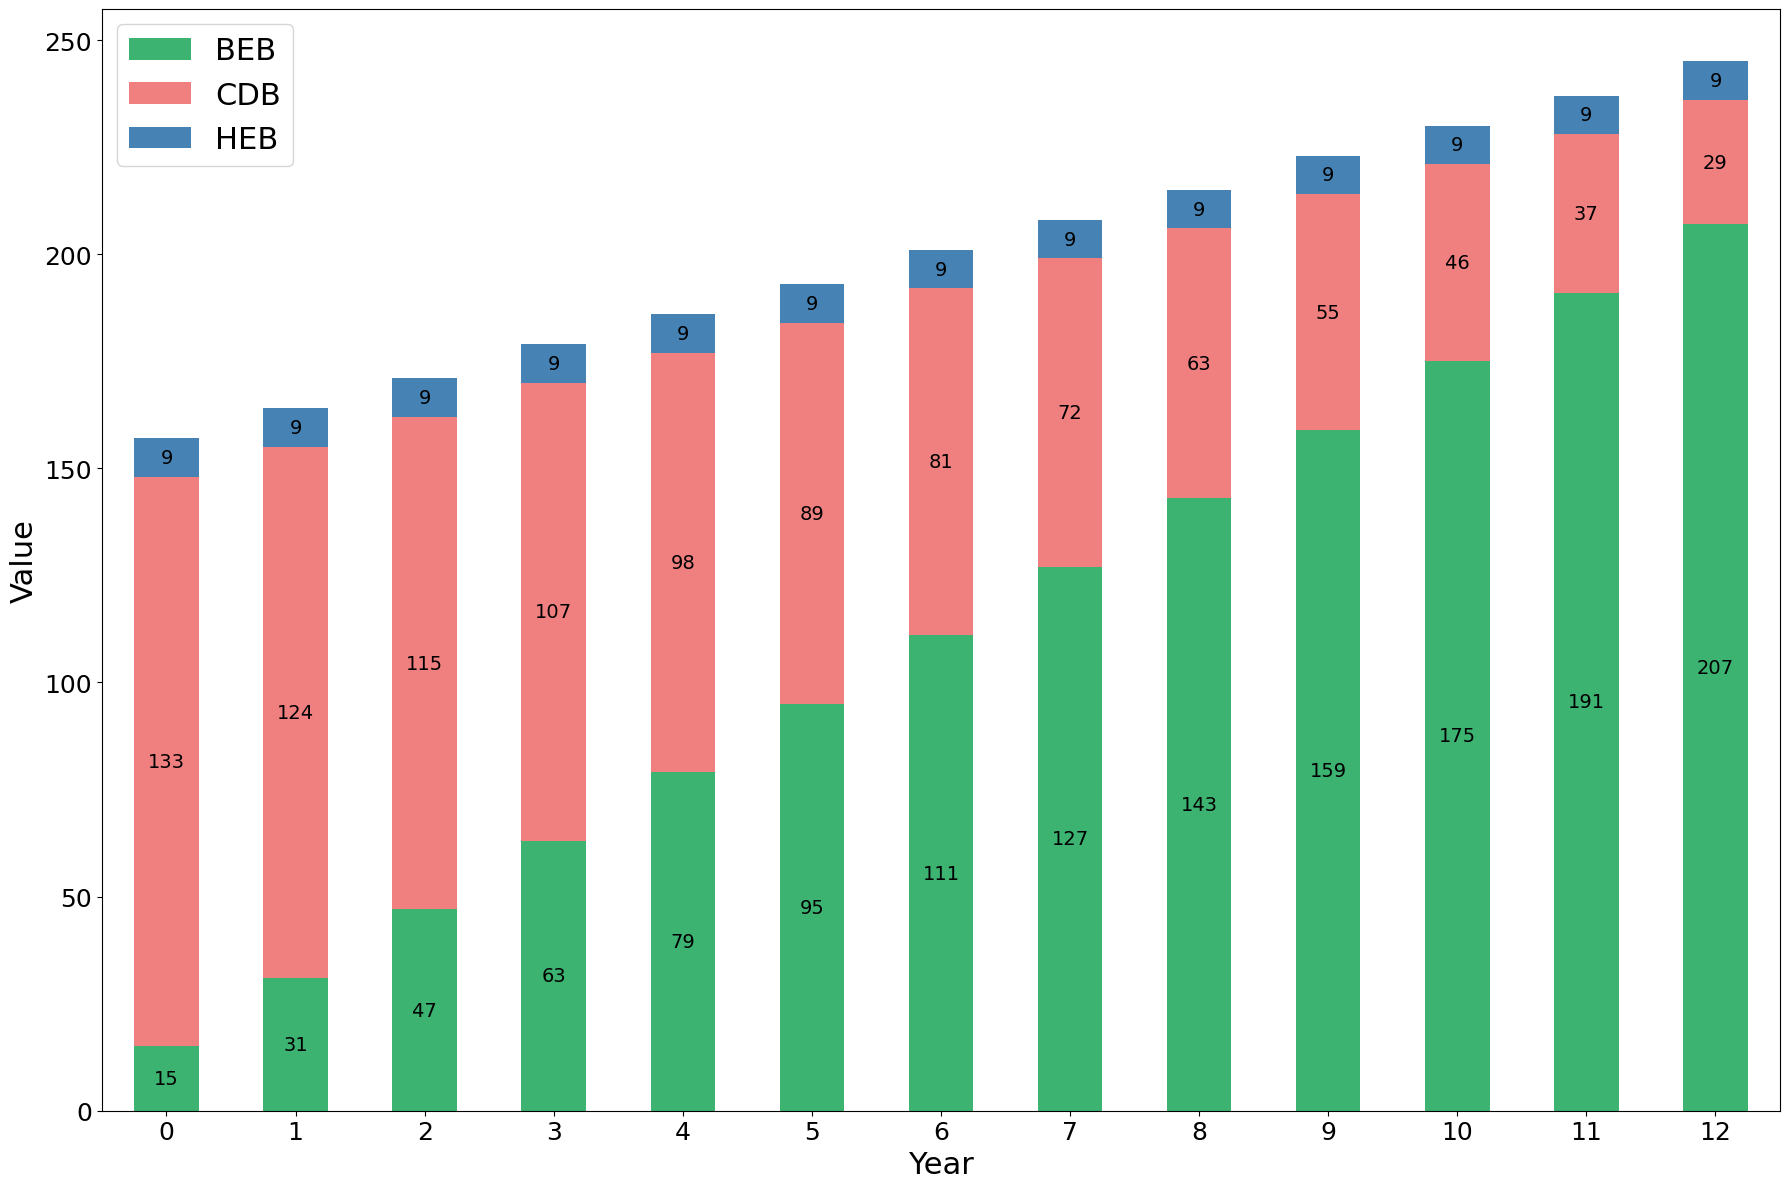

In [211]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = h_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=14)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
fig.savefig(r'../../figures/h_BM_fleet.png', dpi=400)  

plt.show()


In [196]:
### BM Mid-cap Scenario

In [197]:
m_BM_variables = pd.read_csv(r'../../results/midcap-BM-optimized-variables.csv', low_memory=False)

In [198]:
m_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [199]:
# Extract attributes from m_BM_variables
m_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
m_BM_variables = m_BM_variables.dropna()
m_BM_variables['Year'] = m_BM_variables['Year'].astype(int)

# Extract attributes from h_BM_coefficients
m_BM_coefficients[['Scenario', 'Year', 'Trip']] = m_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
m_BM_coefficients = m_BM_coefficients.dropna()
m_BM_coefficients['Year'] = m_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
m_BM_coefficients['Trip'] = m_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(m_BM_coefficients[['Powertrain','Scenario', 'Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Scenario', 'Year', 'Trip',],
                                how='left')

# Update m_BM_variables
m_BM_variables = merged_df

In [200]:
# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update m_BM_variables
m_BM_variables = merged_df

m_BM_variables['ServiceDateTime_min'] = pd.to_datetime(m_BM_variables['ServiceDateTime_min'])
m_BM_variables['ServiceDateTime_max'] = pd.to_datetime(m_BM_variables['ServiceDateTime_max'])

In [201]:
m_BM_variables.to_csv(r'../../results/midcap-BM-optimized-variables-aggregated.csv', index=False)

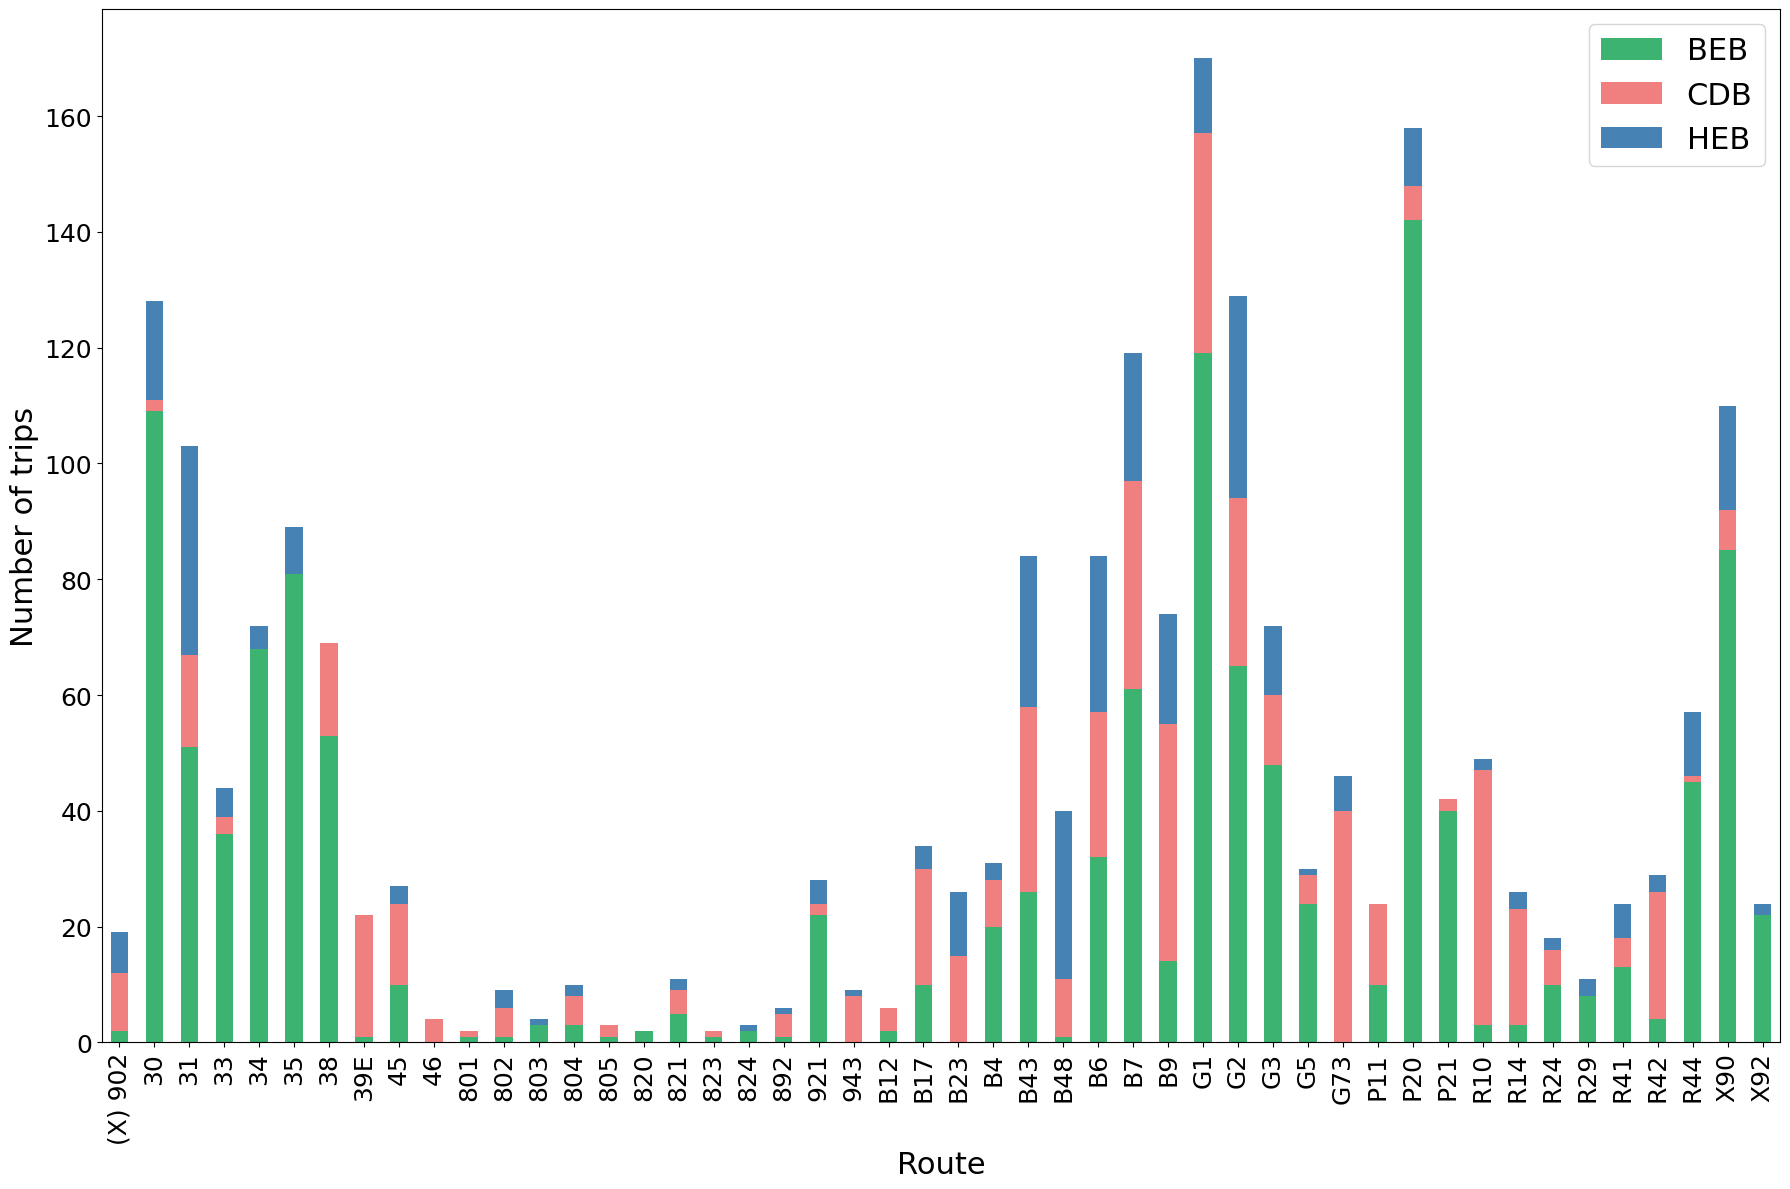

In [202]:
# Filter the dataframe for Year=13 and Value=1
m_BM_variables_filtered = m_BM_variables[(m_BM_variables['Year'] == 12) & (m_BM_variables['Value'] == 1)]
m_BM_variables_filtered = m_BM_variables_filtered[m_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
fig.savefig(r'../../figures/m_BM_route_electrification.png', dpi=400)  

plt.show()


In [203]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 57.72%


In [204]:
m_BM_variables_y = pd.read_csv(r'../../results/midcap-BM-optimized-variables-y.csv', low_memory=False)

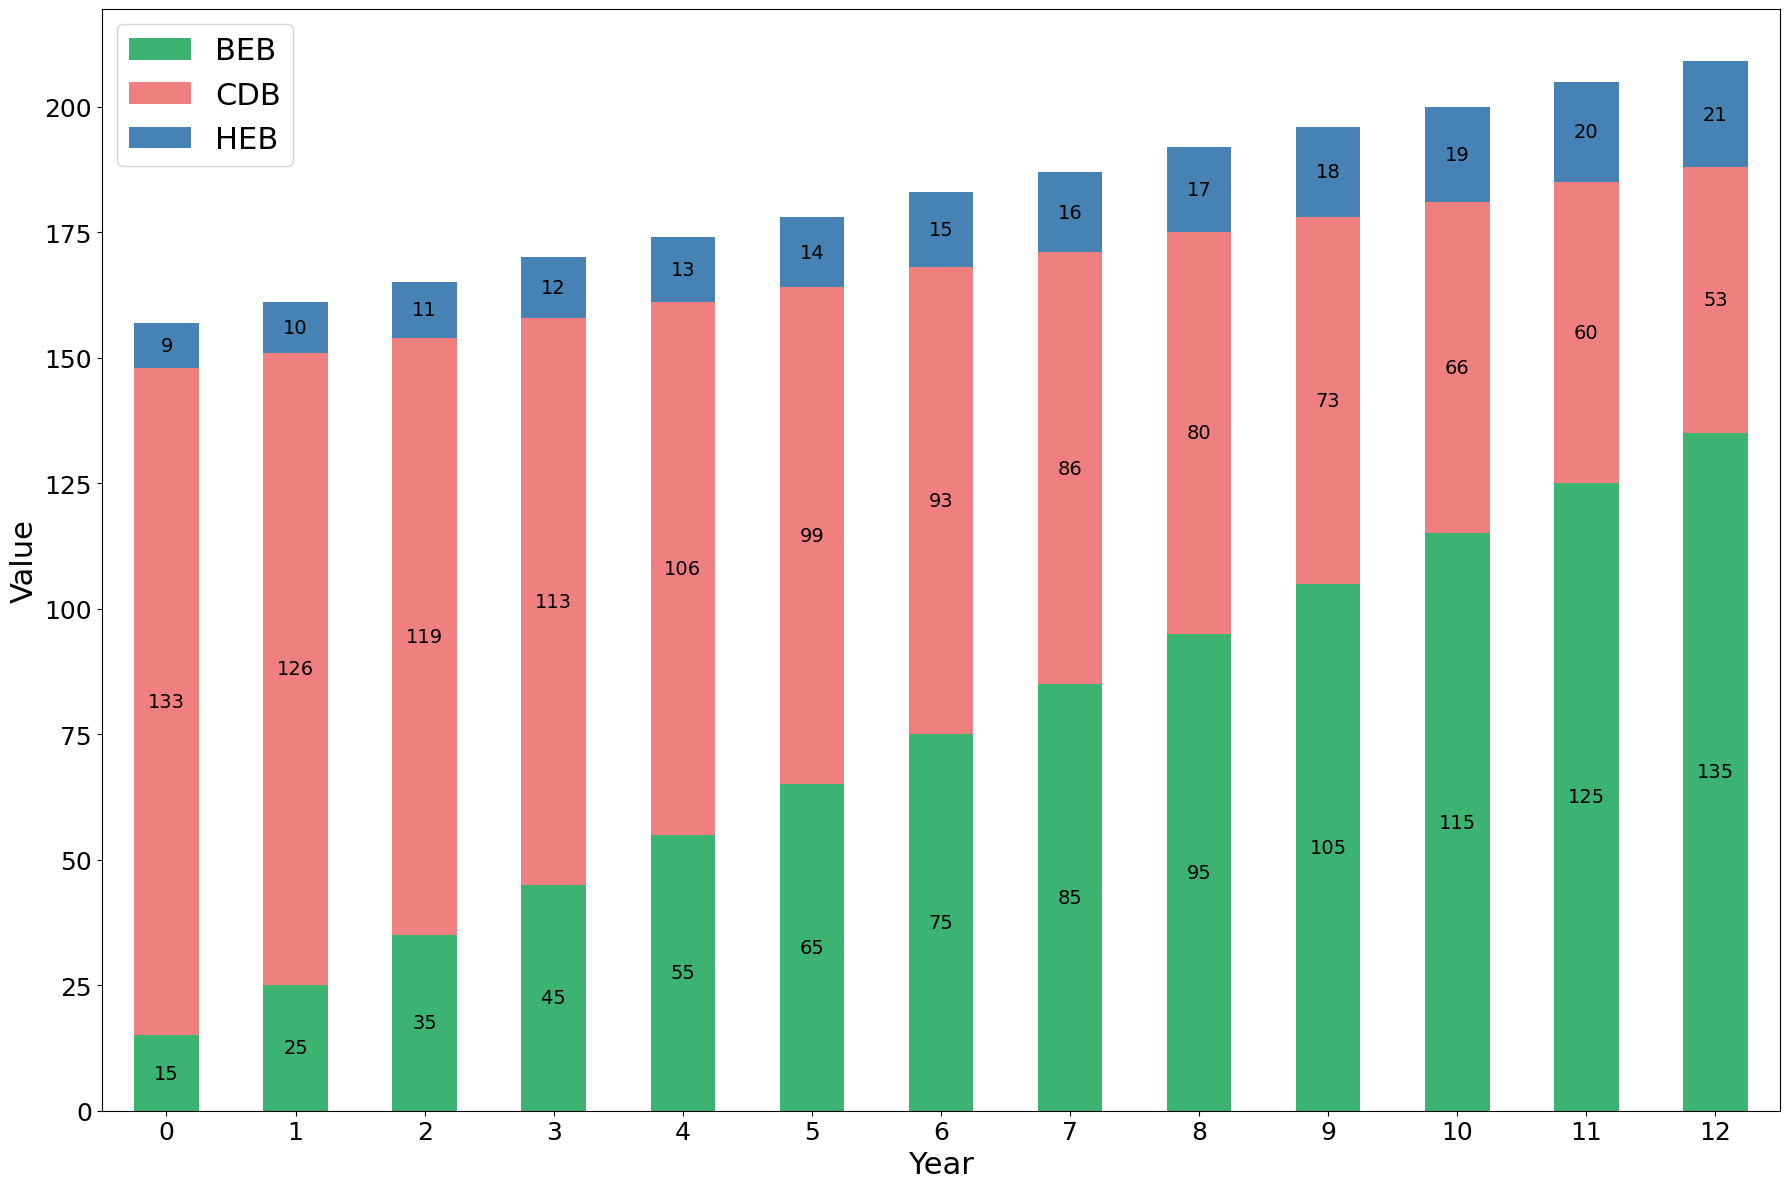

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=14)    

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)
fig.savefig(r'../../figures/m_BM_fleet.png', dpi=400)  

plt.tight_layout()
plt.show()

In [206]:
### BM Low-cap Scenario

In [207]:
l_BM_variables = pd.read_csv(r'../../results/lowcap-BM-optimized-variables.csv', low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../results/lowcap-BM-optimized-variables.csv'

In [ ]:
l_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [ ]:
# Extract attributes from l_BM_variables
l_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
l_BM_variables = l_BM_variables.dropna()
l_BM_variables['Year'] = l_BM_variables['Year'].astype(int)

# Extract attributes from h_BM_coefficients
l_BM_coefficients[['Scenario', 'Year', 'Trip']] = l_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
l_BM_coefficients = l_BM_coefficients.dropna()
l_BM_coefficients['Year'] = l_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_BM_variables['Trip'] = l_BM_variables['Trip'].astype(str)
l_BM_coefficients['Trip'] = l_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(l_BM_coefficients[['Powertrain','Scenario', 'Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Scenario', 'Year', 'Trip',],
                                how='left')

# Update l_BM_variables
l_BM_variables = merged_df

In [ ]:
# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update l_BM_variables
l_BM_variables = merged_df

l_BM_variables['ServiceDateTime_min'] = pd.to_datetime(l_BM_variables['ServiceDateTime_min'])
l_BM_variables['ServiceDateTime_max'] = pd.to_datetime(l_BM_variables['ServiceDateTime_max'])

In [ ]:
l_BM_variables.to_csv(r'../../results/lowcap-BM-optimized-variables-aggregated.csv', index=False)

In [ ]:
# Filter the dataframe for Year=13 and Value=1
l_BM_variables_filtered = l_BM_variables[(l_BM_variables['Year'] == 12) & (l_BM_variables['Value'] == 1)]
l_BM_variables_filtered = l_BM_variables_filtered[l_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
fig.savefig(r'../../figures/l_BM_route_electrification.png', dpi=400)  

plt.show()


In [ ]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


In [ ]:
l_BM_variables_y = pd.read_csv(r'../../results/lowcap-BM-optimized-variables-y.csv', low_memory=False)

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=14)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()

# Save the figure
fig.savefig(r'../../figures/l_BM_fleet.png', dpi=400)  

plt.show()


NameError: name 'l_BM_variables_y' is not defined